In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [39]:
class AutoEncoder(tf.keras.Model):
    
    """
          X
    784 -------------------
        \    encoder      /
         \               /
    32    \_____________/ z 
          /  decoder    \  
         /               \
        /                 \
    784 -------------------
        prime x
        
    REMMBER baia will make this not summertic
   
   """
    
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.regularizer =  None #tf.keras.regularizers.l2(0.01)
        
        # build the aricht
        # Encoder. 
        self.encoder_reshape = tf.keras.layers.Reshape((784,))
        self.encoder_fc1 = tf.keras.layers.Dense(472, activation='relu', kernel_regularizer=self.regularizer)
        self.encoder_fc2 = tf.keras.layers.Dense(236, activation='relu')
        self.encoder_fc3 = tf.keras.layers.Dense(self.latent_dim, activation='relu')
        
        # Decoder.
        self.decoder_fc1 = tf.keras.layers.Dense(236, activation='relu', kernel_regularizer=self.regularizer)
        self.decoder_fc2 = tf.keras.layers.Dense(472, activation='relu')
        self.decoder_fc3 = tf.keras.layers.Dense(784, activation='sigmoid')
        self.decoder_reshape = tf.keras.layers.Reshape((28, 28, 1))
        
        # build the NN
        self._build_graph()
        
    def _build_graph(self):
        # build the network
        input_shape = (28, 28, 1)
        # None is place holder as input_shape is not the demantions
        self.build((None,) + input_shape)
        inputs = tf.keras.Input(shape=input_shape)
        # connent the layers and run call funtion
        _ = self.call(inputs)
        
    
    def call(self, x):
        # run function
        # z is the latent vactor
        z = self.encode(x)
        # the predictor of x 
        x_prime = self.decode(z)
        return x_prime
    
    def encode(self, x):
        x = self.encoder_reshape(x)
        x = self.encoder_fc1(x)
        x = self.encoder_fc2(x)
        z = self.encoder_fc3(x)
        return z
    
    def decode(self, z):
        z = self.decoder_fc1(z)
        z = self.decoder_fc2(z)
        z = self.decoder_fc3(z)
        x_prime = self.decoder_reshape(z)
        return x_prime

autoencoder = AutoEncoder(32)
print(autoencoder.latent_dim)
print(autoencoder.encoder_reshape)
print(autoencoder.decoder_reshape)

autoencoder.summary()

autoencoder.compile( optimizer='adam', # nice to start with rmsprop this nice to start as it realtive computation lighty  
                    loss='binary_crossentropy', # using binary_cossentropy as we are calssifying a pixel for pixel (is the result pixel the same as the input puxel)
                    metrics=['accuracy'] # for us the see
                   )

32
Model: "auto_encoder_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 784)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 472)               370520    
_________________________________________________________________
dense_31 (Dense)             (None, 236)               111628    
_________________________________________________________________
dense_32 (Dense)             (None, 32)                7584      
_________________________________________________________________
dense_33 (Dense)             (None, 236)               7788      
_________________________________________________________________
dense_34 (Dense)             (None, 472)               111864    
_________________________________________________________________
dense_35 (Dense)             (None, 784)         

In [40]:
(mnist_train_original, mnist_validate_original, mnist_test_original), info = \
tfds.load(name='mnist',
          split=['train[:80%]', 'train[80%:]', 'test'], 
          with_info=True, 
          as_supervised=True
         )
def encode(image):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # as I expect that the input will be the same as the output some I use the input also as the label 
    return image_encoded, image_encoded

minst_train = mnist_train_original.map(lambda image, _: encode(image)).cache()
minst_validate = mnist_validate_original.map(lambda image, _: encode(image)).cache()
minst_test = mnist_test_original.map(lambda image, _: encode(image)).cache()

In [41]:
def render_predictions():
    
    mnist_examples = list( minst_train.take(8).as_numpy_iterator())
    
    index = 1
    plt.figure(figsize=(8, 2))
    for image, _ in mnist_examples:
        prediction = autoencoder.predict(np.array([image]))[0]
        plt.subplot(2, 8, index)
        plt.axis('off')
        plt.imshow(image[:,:,0], cmap='inferno')
        plt.subplot(2, 8, index + 8)
        plt.axis('off')
        plt.imshow(prediction[:,:,0], cmap='inferno')
        index += 1
    plt.show()
    plt.close()

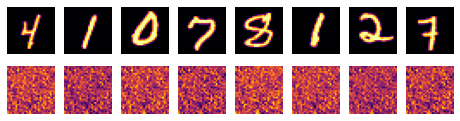

In [42]:
render_predictions()

In [43]:
history = autoencoder.fit(minst_train.shuffle(10_000).batch(32),
                         epochs=68,
                          validation_data=minst_validate.batch(32)
                         )

Epoch 1/68
1500/1500 [==============================] - 14s 9ms/step - loss: 0.1322 - accuracy: 0.8078 - val_loss: 0.1006 - val_accuracy: 0.8131
Epoch 2/68
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0951 - accuracy: 0.8135 - val_loss: 0.0913 - val_accuracy: 0.8143
Epoch 3/68
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0893 - accuracy: 0.8140 - val_loss: 0.0883 - val_accuracy: 0.8147
Epoch 4/68
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0866 - accuracy: 0.8143 - val_loss: 0.0867 - val_accuracy: 0.8147
Epoch 5/68
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0850 - accuracy: 0.8144 - val_loss: 0.0855 - val_accuracy: 0.8147
Epoch 6/68
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0839 - accuracy: 0.8145 - val_loss: 0.0847 - val_accuracy: 0.8148
Epoch 7/68
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0830 - accuracy: 0.8146 - val_loss: 0.0840 - val_accu

In [44]:
def plot_history(history): 

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
    plt.close()

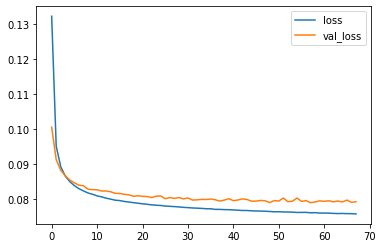

In [45]:
plot_history(history)

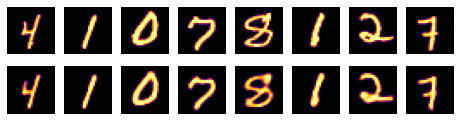

In [9]:
render_predictions()

In [50]:
def render_dataset():
    mnist_examples = list(minst_train.take(8).as_numpy_iterator())
    index = 1
    plt.figure(figsize=(8, 2))
    for image_in, image_out in mnist_examples:
        plt.subplot(2, 8, index)
        plt.axis("off")
        plt.imshow(image_in[:,:,0], cmap="inferno")
        plt.subplot(2, 8, index + 8)
        plt.axis("off")
        plt.imshow(image_out[:,:,0], cmap="inferno")
        index += 1
    plt.show()
    plt.close()

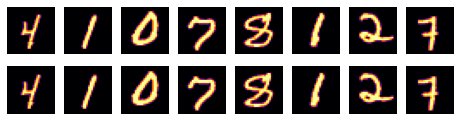

In [51]:
render_dataset()